<a href="https://colab.research.google.com/github/Syedboo/Stock-Prediction-Using-News-Sentiment/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Historical Data - Extracting data and Merging them**

---



In [ ]:
pip install transformers torch


In [ ]:
import json
from datetime import datetime
import pandas as pd
from transformers import pipeline

# Load the articles data from JSON file
with open('/content/sample_data/articles_data_sainsb.json', 'r') as file:
    articles = json.load(file)

# Process articles to extract and convert dates
for article in articles:
    # Check if the date field exists and is not empty
    if "date" in article and article["date"]:
        # Convert the date into datetime object
        date_time = datetime.strptime(article["date"], "%a, %d %b %Y %H:%M:%S GMT")

        # Extract the actual date and time
        # Convert date object to ISO format string for JSON serialization
        article["actual_date"] = date_time.date().isoformat() # Changed this line
        article["time"] = date_time.time().strftime("%H:%M:%S")

        # Initialize sentiment analysis pipeline
        sentiment_pipeline = pipeline("sentiment-analysis")

        # Truncate the text to the maximum length allowed by the model
        text = article["text"][:512]

        # Get sentiment analysis results
        sentiment_result = sentiment_pipeline(text)[0]

        # Convert the sentiment label to a score between 0 and 1
        sentiment_label = sentiment_result['label']
        sentiment_score = sentiment_result['score']
        if sentiment_label == "NEGATIVE":
            sentiment_score = 1 - sentiment_score  # Invert score for negative sentiment

        # Assign sentiment score to the article
        article["sentiment_score"] = sentiment_score
        article["insights"] = sentiment_result['label']
    else:
        # Handle missing dates (e.g., set to None, skip, etc.)
        article["actual_date"] = None
        article["time"] = None
        article["sentiment_score"] = None
        article["insights"] = None

# Save processed articles to a new JSON file
with open('processed_articles_data.json', 'w') as file:
    json.dump(articles, file, indent=4)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was sup

**2. Load Historical Stock Price Data**

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define the stock symbol and time period
stock_symbol = 'SBRY.L'
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Fetch the stock data
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Save the data to a CSV file
csv_file = 'sbrl_l_stock_data.csv'
stock_data.to_csv(csv_file)

# Load stock price data from CSV
stock_data = pd.read_csv(csv_file)

# Ensure the date column is in datetime format
# The date column is not explicitly saved, so we create one from the index
stock_data['Date'] = pd.to_datetime(stock_data.index)

# Drop the old index column if it exists
stock_data.reset_index(drop=True, inplace=True)

# Sort by date for consistency
stock_data = stock_data.sort_values(by='Date')

# Save the sorted data back to a CSV file
sorted_csv_file = 'sbrl_l_stock_data_sorted.csv'
stock_data.to_csv(sorted_csv_file, index=False)

print(f"Stock data for {stock_symbol} has been saved to {csv_file} and sorted data saved to {sorted_csv_file}")


[*********************100%***********************]  1 of 1 completed

Stock data for SBRY.L has been saved to sbrl_l_stock_data.csv and sorted data saved to sbrl_l_stock_data_sorted.csv


In [ ]:
# Load stock price data from CSV
stock_data = pd.read_csv('/content/sbrl_l_stock_data.csv')

# Ensure the date column is in datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Sort by date for consistency
stock_data = stock_data.sort_values(by='Date')


**3. Merge historical data**

In [ ]:
import json

# Load articles with sentiment and insights
with open('processed_articles_data.json', 'r') as file:
    articles = json.load(file)

# Convert articles to DataFrame
articles_df = pd.DataFrame(articles)

# Convert the 'actual_date' column to datetime
articles_df['actual_date'] = pd.to_datetime(articles_df['actual_date'])

# Merge the stock data with articles data on date
merged_df = pd.merge(stock_data, articles_df, left_on='Date', right_on='actual_date', how='left')

# Save the merged data to a new CSV file
merged_df.to_csv('merged_stock_articles_data.csv', index=False)


**Forward fill**

In [ ]:
import pandas as pd

# Load the merged data with missing values
merged_df = pd.read_csv('/content/merged_stock_articles_data.csv')

# Forward fill missing values for sentiment_score and other columns
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(method='ffill')
merged_df['insights'] = merged_df['insights'].fillna(method='ffill')
merged_df['text'] = merged_df['text'].fillna(method='ffill')
merged_df['title'] = merged_df['title'].fillna(method='ffill')

# Impute remaining null values in sentiment_score with 0.5
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0.5)

# Save the updated dataset
merged_df.to_csv('merged_stock_articles_data_filled_forward.csv', index=False)

print("Missing values have been forward filled and sentiment_score nulls imputed with 0.5.")


Missing values have been forward filled and sentiment_score nulls imputed with 0.5.


<ipython-input-10-e2fd31b479ea>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(method='ffill')
<ipython-input-10-e2fd31b479ea>:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['insights'] = merged_df['insights'].fillna(method='ffill')
<ipython-input-10-e2fd31b479ea>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['text'] = merged_df['text'].fillna(method='ffill')
<ipython-input-10-e2fd31b479ea>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df['title'] = merged_df['title'].fillna(method='ffill')


# Building the model

**Step 1: Prepare the Data**

In [ ]:
import pandas as pd

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Keep only sentiment and open related columns
data = data[['Open', 'sentiment_score','High','Low','Close']]

# Display the first few rows of the data
print(data.head())


                  Open  sentiment_score        High         Low       Close
Date                                                                       
2023-09-25  272.799988              0.5  273.299988  268.399994  269.399994
2023-09-26  268.600006              0.5  270.000000  260.000000  261.700012
2023-09-27  260.899994              0.5  261.700012  252.600006  252.600006
2023-09-28  252.899994              0.5  253.899994  249.800003  250.300003
2023-09-29  252.500000              0.5  255.000000  251.500000  252.800003


                  Open  sentiment_score        High         Low       Close  \
Date                                                                          
2023-09-25  272.799988              0.5  273.299988  268.399994  269.399994   
2023-09-26  268.600006              0.5  270.000000  260.000000  261.700012   
2023-09-27  260.899994              0.5  261.700012  252.600006  252.600006   
2023-09-28  252.899994              0.5  253.899994  249.800003  250.300003   
2023-09-29  252.500000              0.5  255.000000  251.500000  252.800003   

            sentiment_lag_1  sentiment_lag_2  sentiment_roll_mean_3  \
Date                                                                  
2023-09-25         0.478366         0.480015               0.478291   
2023-09-26         0.500000         0.480015               0.478291   
2023-09-27         0.500000         0.500000               0.500000   
2023-09-28         0.500000         0.500000               0.500000   
2023-09-29         0

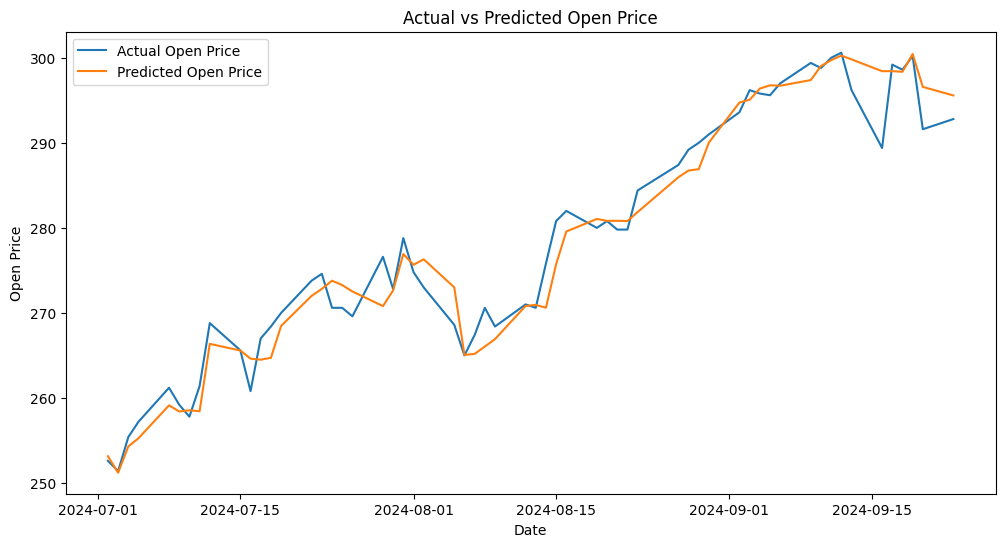

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Replace with your data file path

# The 'Date' column is already the index, no need to convert and set it again.
#data['Date'] = pd.to_datetime(data['Date'])
#data.set_index('Date', inplace=True)
#data.sort_index(inplace=True)

# Feature Engineering: Adding Technical Indicators
data['sentiment_lag_1'] = data['sentiment_score'].shift(1)
data['sentiment_lag_2'] = data['sentiment_score'].shift(2)
data['sentiment_roll_mean_3'] = data['sentiment_score'].rolling(window=3).mean()
data['sentiment_roll_std_3'] = data['sentiment_score'].rolling(window=3).std()
data['open_roll_mean_3'] = data['Open'].rolling(window=3).mean()
data['open_roll_std_3'] = data['Open'].rolling(window=3).std()

# Adding Moving Averages
data['MA10'] = data['Open'].rolling(window=10).mean()
data['MA50'] = data['Open'].rolling(window=50).mean()

# Adding Volatility
data['Volatility'] = data['Open'].rolling(window=10).std()

# Impute missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns, index=data.index)

print(data_imputed.head())
data_imputed.to_csv('Stock_price_dataset.csv', index=False)
# Select features and target
features = ['sentiment_score', 'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_roll_mean_3', 'sentiment_roll_std_3',
            'open_roll_mean_3', 'open_roll_std_3', 'MA10', 'MA50', 'Volatility']
target = 'Open'

# Train-test split
train_size = int(len(data_imputed) * 0.8)
train = data_imputed[:train_size]
test = data_imputed[train_size:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Model Training with Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual Open Price')
plt.plot(test.index, y_pred, label='Predicted Open Price')
plt.title('Actual vs Predicted Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()

Modifying the above code to include signals

MSE: 7.9032780168813686
MAE: 1.9851010030110652
RMSE: 2.8112769370663875
Day 0: Buy - Predicted increase of 3.36% by Day 4
Day 1: Buy - Predicted increase of 3.20% by Day 4
Day 2: Buy - Predicted increase of 3.17% by Day 4
Day 3: Buy - Predicted increase of 2.51% by Day 4
Day 4: Buy - Predicted increase of 2.37% by Day 10
Day 5: Buy - Predicted increase of 2.21% by Day 12
Day 6: Buy - Predicted increase of 2.05% by Day 11
Day 7: Buy - Predicted increase of 2.08% by Day 11
Day 8: Buy - Predicted increase of 2.10% by Day 11
Day 9: Buy - Predicted increase of 2.14% by Day 12
Day 10: Buy - Predicted increase of 3.10% by Day 14
Day 11: Buy - Predicted increase of 2.82% by Day 14
Day 12: Buy - Predicted increase of 2.57% by Day 14
Day 13: Buy - Predicted increase of 2.05% by Day 16
Day 14: Hold - No significant change found
Day 15: Hold - No significant change found
Day 16: Hold - No significant change found
Day 17: Hold - No significant change found
Day 18: Hold - No significant change foun

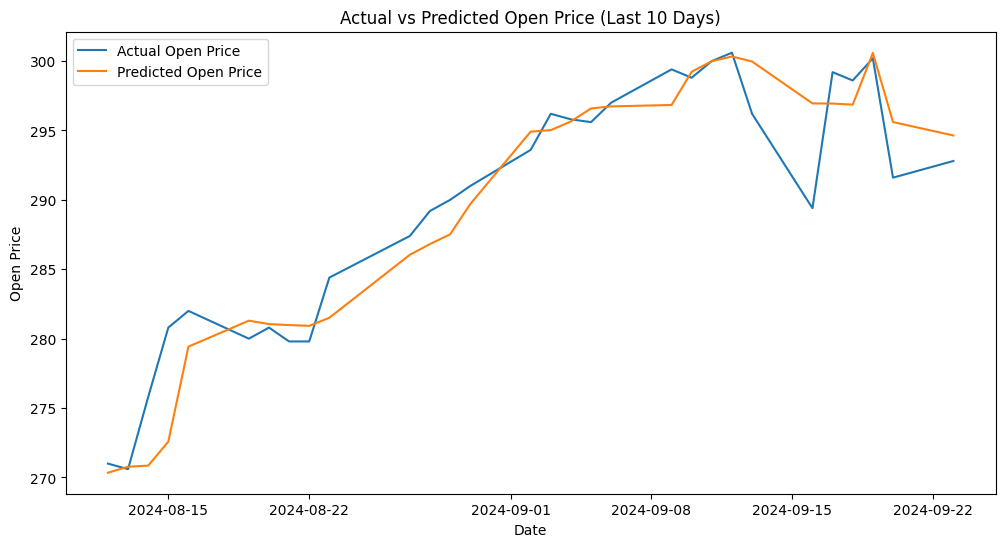

Model saved to random_forest_model.pkl


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Feature Engineering: Adding Technical Indicators
data['sentiment_lag_1'] = data['sentiment_score'].shift(1)
data['sentiment_lag_2'] = data['sentiment_score'].shift(2)
data['sentiment_roll_mean_3'] = data['sentiment_score'].rolling(window=3).mean()
data['sentiment_roll_std_3'] = data['sentiment_score'].rolling(window=3).std()
data['open_roll_mean_3'] = data['Open'].rolling(window=3).mean()
data['open_roll_std_3'] = data['Open'].rolling(window=3).std()

# Adding Moving Averages
data['MA10'] = data['Open'].rolling(window=10).mean()
data['MA50'] = data['Open'].rolling(window=50).mean()

# Adding Volatility
data['Volatility'] = data['Open'].rolling(window=10).std()

# Impute missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns, index=data.index)

# Select features and target
features = ['sentiment_score', 'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_roll_mean_3', 'sentiment_roll_std_3',
            'open_roll_mean_3', 'open_roll_std_3', 'MA10', 'MA50', 'Volatility']
target = 'Open'

# Define the number of days for testing
test_days = 30  # You can adjust this value as needed

# Train-test split
train_size = len(data_imputed) - test_days
train = data_imputed[:train_size]
test = data_imputed[train_size:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Model Training with Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Function to calculate trading signals
def trading_signal(predicted_prices, threshold=0.02):
    """
    Generate trading signals based on predicted prices.

    :param predicted_prices: List or array of predicted prices.
    :param threshold: The percentage change threshold to consider.
    :return: List of signals indicating 'buy', 'sell', or 'hold'.
    """
    signals = []
    n = len(predicted_prices)

    for i in range(n - 1):
        signal_found = False
        for j in range(i + 1, n):
            # Calculate percentage change
            change = (predicted_prices[j] - predicted_prices[i]) / predicted_prices[i]
            if abs(change) > threshold:
                # Determine signal based on change direction
                if change > 0:
                    signals.append(f"Day {i}: Buy - Predicted increase of {change*100:.2f}% by Day {j}")
                else:
                    signals.append(f"Day {i}: Sell - Predicted decrease of {change*100:.2f}% by Day {j}")
                signal_found = True
                break

        if not signal_found:
            signals.append(f"Day {i}: Hold - No significant change found")

    return signals

# Call the trading_signal function with predicted prices
signals = trading_signal(y_pred)

# Output the signals
for signal in signals:
    print(signal)

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual Open Price')
plt.plot(test.index, y_pred, label='Predicted Open Price')
plt.title('Actual vs Predicted Open Price (Last 10 Days)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()

import joblib

# Save the model
model_filename = 'random_forest_model.pkl'
joblib.dump(model, model_filename)
print(f'Model saved to {model_filename}')



In [ ]:
import numpy as np
import requests
from lxml import html
from datetime import datetime, timedelta
from transformers import pipeline
import re
import json


# Load the model
loaded_model = joblib.load("/content/random_forest_model.pkl")
print(f'Model loaded from {model_filename}')

import pandas as pd
from sklearn.impute import SimpleImputer

def forecast_next_days(new_sentiment_score, model, initial_data, features, imputer, days=1):
    """
    Forecast the next `days` days based on the initial data using the provided model.

    :param model: The trained model.
    :param initial_data: DataFrame containing the latest data for prediction.
    :param features: List of feature names used in the model.
    :param imputer: The imputer used to handle missing values.
    :param days: Number of days to forecast.
    :return: List of forecasts for the next `days` days.
    """
    forecasts = []
    data = initial_data.copy()

    for _ in range(days):
        # Prepare features for prediction
        latest_features = data[features].values

        # Ensure no NaN values
        latest_features = imputer.transform(latest_features)

        # Predict the next day's price
        next_day_price = model.predict(latest_features)[0]
        forecasts.append(next_day_price)

        # Update the data with the new prediction
        new_row = data.iloc[-1:].copy()
        new_row['Open'] = next_day_price
        new_row['sentiment_lag_1'] = new_sentiment_score
        new_row['sentiment_lag_2'] = data['sentiment_score'].iloc[-1]
        new_row['sentiment_roll_mean_3'] = data['sentiment_score'].iloc[-3:].mean()
        new_row['sentiment_roll_std_3'] = data['sentiment_score'].iloc[-3:].std()
        new_row['open_roll_mean_3'] = data['Open'].iloc[-3:].mean()
        new_row['open_roll_std_3'] = data['Open'].iloc[-3:].std()
        new_row['MA10'] = data['Open'].iloc[-10:].mean()
        new_row['MA50'] = data['Open'].iloc[-50:].mean()
        new_row['Volatility'] = data['Open'].iloc[-10:].std()

        # Append new_row to data
        data = pd.concat([data, new_row], ignore_index=True)

    return forecasts

# Example usage
initial_data = data_imputed.iloc[-1:]  # Latest row of data
forecast_days = 1

print(initial_data)

#To extract recent news and apphend it to predict tomorrow's price

# Define the URL
url = 'https://news.google.com/search?q=sainsburys&hl=en-GB&gl=GB&ceid=GB%3Aen'

# Make a request to the website
response = requests.get(url)

# Parse the page content
tree = html.fromstring(response.content)

# Define the XPaths
title_xpath = "//div[@class='UW0SDc']//a//text()"
time_xpath = "//div[@class='UW0SDc']//time//text()"

# Extract data using XPath
titles = tree.xpath(title_xpath)
times = tree.xpath(time_xpath)


# Helper function to format dates
def format_time(time_str):
    time_str = time_str.strip()

    if time_str.lower() == 'yesterday':
        return (datetime.now() - timedelta(days=1)).strftime('%d %b %Y')

    if 'hours ago' in time_str:
        hours_ago = int(time_str.split()[0])
        return (datetime.now() - timedelta(hours=hours_ago)).strftime('%d %b %Y')

    if 'days ago' in time_str:
        days_ago = int(time_str.split()[0])
        return (datetime.now() - timedelta(days=days_ago)).strftime('%d %b %Y')

    # Handle dates in 'd MMM' format (e.g., '13 Jul')
    try:
        return datetime.strptime(time_str, '%d %b').replace(year=datetime.now().year).strftime('%d %b %Y')
    except ValueError:
        # Handle dates in 'd MMM yyyy' format (e.g., '9 Dec 2023')
        try:
            return datetime.strptime(time_str, '%d %b %Y').strftime('%d %b %Y')
        except ValueError:
            return time_str  # Return the original string if parsing fails


# Combine titles and times into a list of tuples
results = list(zip(titles, times))


def parse_time(time_str):
    """Convert a time string into a datetime object."""
    now = datetime.now()

    # Check for relative times
    relative_time_match = re.match(r'(\d+) hours? ago', time_str)
    if relative_time_match:
        hours_ago = int(relative_time_match.group(1))
        return now - timedelta(hours=hours_ago)

    # Check for absolute dates
    try:
        return datetime.strptime(time_str, "%d %b %Y")
    except ValueError:
        raise ValueError(f"Unrecognized time format: {time_str}")


# Step 1: Find the most recent date
most_recent_title = None
most_recent_time = None


for title, time_str in results:
    try:
        time_obj = parse_time(time_str)
        if most_recent_time is None or time_obj > most_recent_time:
            most_recent_time = time_obj
            most_recent_title = title
    except ValueError as e:
        pass  # Print error for unrecognized formats



# Step 3: Get sentiment score using transformers
if most_recent_title:
    sentiment_pipeline = pipeline("sentiment-analysis")
    sentiment_result = sentiment_pipeline(most_recent_title)
    sentiment_score = sentiment_result[0]['score']
    sentiment_label = sentiment_result[0]['label']
    if sentiment_label == "NEGATIVE":
        sentiment_score = 1 - sentiment_score
    #print(f"Sentiment Score: {sentiment_score}")

else:
    #Neutral
    sentiment_score = 0.5




#Updating the news to articles_data file for future predictions
# Path to the JSON file
file_path = '/content/sample_data/articles_data_sainsb.json'

# New details
new_title = most_recent_title
new_author = "N/A"
new_text = most_recent_title
new_url = "N/A"

# Get today's date in the required format
today_date = datetime.now().strftime("%a, %d %b %Y %H:%M:%S GMT")

# Create a new dictionary with the details
new_article = {
    "title": new_title,
    "author": new_author,
    "date": today_date,
    "text": new_text,
    "url": new_url
}

# Load the existing data from the JSON file
with open(file_path, 'r') as file:
    articles = json.load(file)

# Append the new article to the list
articles.append(new_article)

# Write the updated list back to the JSON file
with open(file_path, 'w') as file:
    json.dump(articles, file, indent=4)

#print("New article added to the JSON file.")
#DONE - Updating the news to articles_data file for future predictions

new_sentiment_score = sentiment_score
# Initialize the imputer (use the one from your training process)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform the initial data
imputer.fit(data_imputed[features])
future_prices = forecast_next_days(new_sentiment_score, loaded_model, initial_data, features, imputer, days=forecast_days)
print(f"Forecasted price for the next {forecast_days} day: {future_prices}")


Model loaded from random_forest_model.pkl
                  Open  sentiment_score        High         Low       Close  \
Date                                                                          
2024-09-23  292.799988         0.001747  294.799988  291.200012  294.600006   

            sentiment_lag_1  sentiment_lag_2  sentiment_roll_mean_3  \
Date                                                                  
2024-09-23         0.001747         0.001747               0.001747   

            sentiment_roll_std_3  open_roll_mean_3  open_roll_std_3  \
Date                                                                  
2024-09-23                   0.0        294.866669         4.657618   

                  MA10        MA50  Volatility  
Date                                            
2024-09-23  296.740002  281.891999    4.046456  


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Forecasted price for the next 1 day: [294.6379962158203]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Trying with LSTM

Shape of X_train: (145, 60, 14), Shape of y_train: (145,)
Shape of X_test: (37, 60, 14), Shape of y_test: (37,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - loss: 0.0889 - val_loss: 0.1155
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0174 - val_loss: 0.0905
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.0119 - val_loss: 0.0369
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.0073 - val_loss: 0.0665
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 0.0083 - val_loss: 0.0667
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.0071 - val_loss: 0.0797
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - loss: 0.0063 - val_loss: 0.0903
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.0058 - val_loss: 0.0753
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0055 - val_loss: 0.0818
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.0052 - val_loss: 0.0727
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - loss: 0.0041 - val_loss: 0.0744
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.0043 - val_l

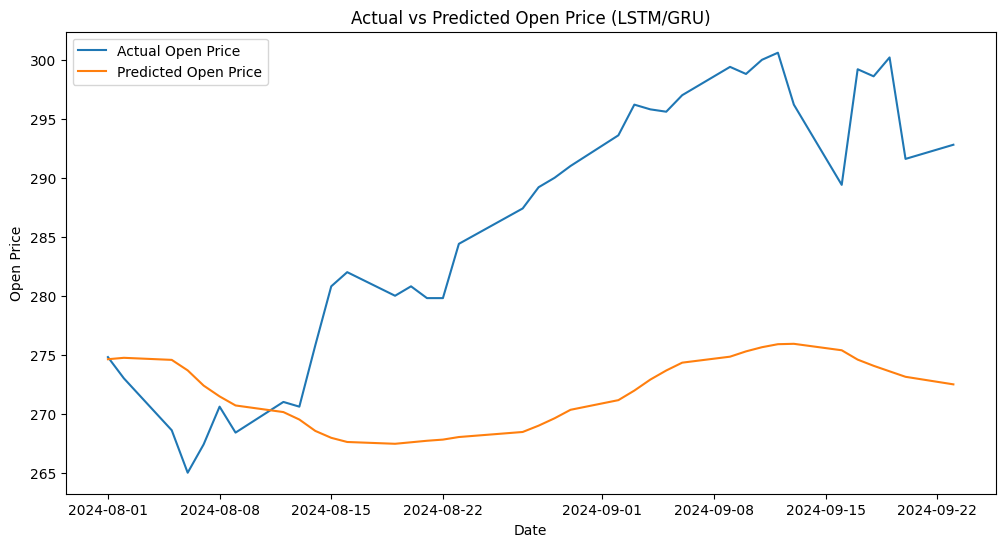

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Keep only sentiment and open related columns
data = data[['Open', 'sentiment_score','High','Low','Close']]

# Feature Engineering: Adding Technical Indicators
data['sentiment_lag_1'] = data['sentiment_score'].shift(1)
data['sentiment_lag_2'] = data['sentiment_score'].shift(2)
data['sentiment_roll_mean_3'] = data['sentiment_score'].rolling(window=3).mean()
data['sentiment_roll_std_3'] = data['sentiment_score'].rolling(window=3).std()
data['open_roll_mean_3'] = data['Open'].rolling(window=3).mean()
data['open_roll_std_3'] = data['Open'].rolling(window=3).std()
data['MA10'] = data['Open'].rolling(window=10).mean()
data['MA50'] = data['Open'].rolling(window=50).mean()
data['Volatility'] = data['Open'].rolling(window=10).std()

# Drop missing values after feature engineering
data.dropna(inplace=True)

# Scaling the features for LSTM/GRU
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Creating sequences (input and target for LSTM/GRU)
def create_sequences(data, target_column, sequence_length=60):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, target_column])  # Target is the 'Open' price
    return np.array(X), np.array(y)

# Set target column index (here, 'Open' is the 0th column)
target_column = 0
sequence_length = 60

X, y = create_sequences(scaled_data, target_column, sequence_length)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM/GRU input (samples, time steps, features)
print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")

# Build the LSTM/GRU Model
model = Sequential()

# LSTM or GRU layers (you can switch between LSTM and GRU by replacing the respective layer)
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Alternatively, use GRU instead of LSTM:
# model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))
# model.add(GRU(units=100, return_sequences=False))
# model.add(Dropout(0.2))

# Output layer (single output for the 'Open' price)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict on test data
y_pred = model.predict(X_test)

# Inverse scaling to get the original price
y_test_scaled = np.zeros((len(y_test), scaled_data.shape[1]))
y_test_scaled[:, target_column] = y_test
y_test_original = scaler.inverse_transform(y_test_scaled)[:, target_column]

y_pred_scaled = np.zeros((len(y_pred), scaled_data.shape[1]))
y_pred_scaled[:, target_column] = y_pred.flatten()
y_pred_original = scaler.inverse_transform(y_pred_scaled)[:, target_column]

# Model Evaluation
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

# Plot Actual vs Predicted Open Price
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_original, label='Actual Open Price')
plt.plot(data.index[-len(y_pred):], y_pred_original, label='Predicted Open Price')
plt.title('Actual vs Predicted Open Price (LSTM/GRU)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()


Training with ARIMA and SARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA MSE: 380.08693071389985
ARIMA MAE: 15.783872958662196
ARIMA RMSE: 19.495818287876503


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


SARIMA MSE: 439.02171116111367
SARIMA MAE: 16.97903950672233
SARIMA RMSE: 20.952844941943173


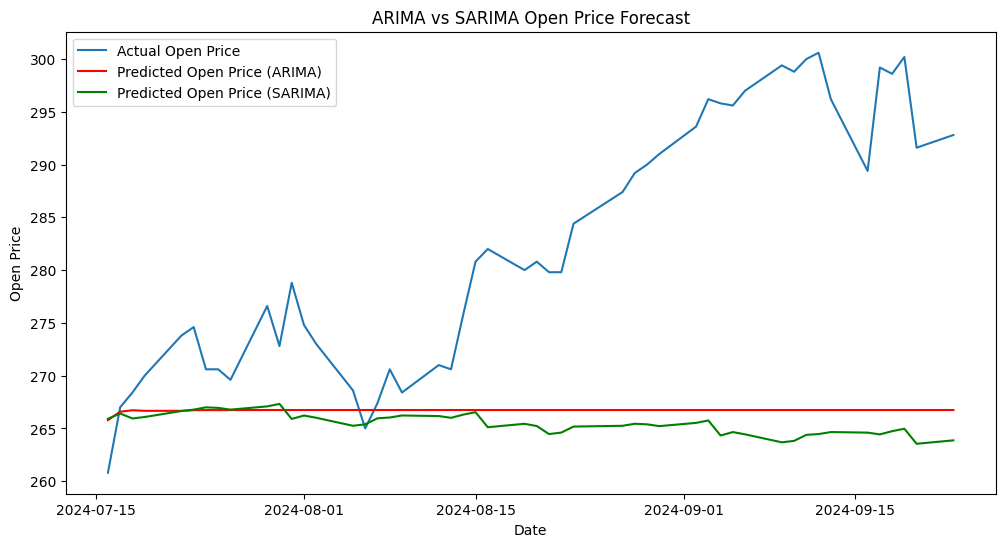

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - loss: 0.1129 - val_loss: 0.0968
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0211 - val_loss: 0.1078
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0123 - val_loss: 0.0347
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0132 - val_loss: 0.0493
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0053 - val_loss: 0.0544
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0063 - val_loss: 0.0433
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0063 - val_loss: 0.0699
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0053 - val_loss: 0.0755
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0060 - val_loss: 0.0750
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0055 - val_loss: 0.0728
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0043 - val_loss: 0.0639
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0051 - val_loss: 0.0

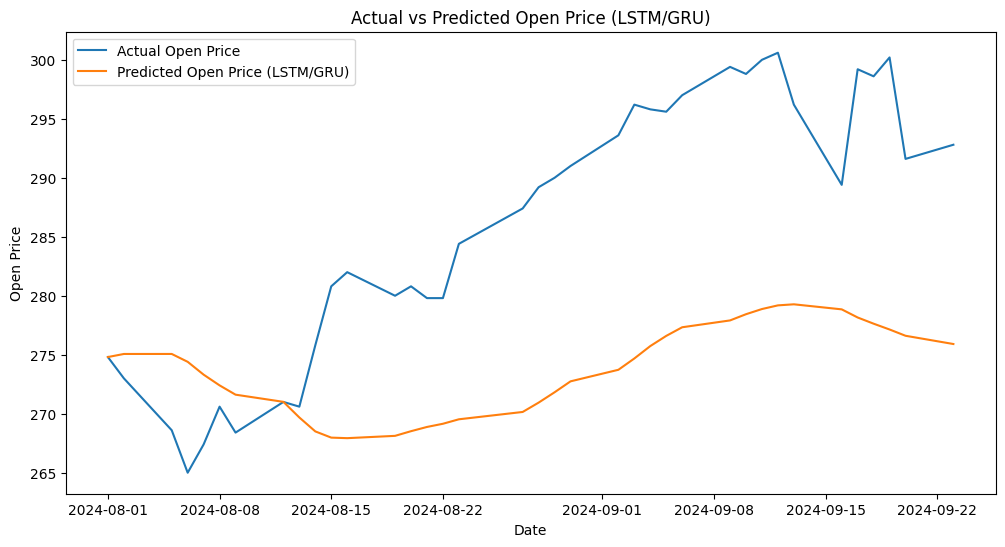

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Keep only sentiment and open related columns
data = data[['Open', 'sentiment_score','High','Low','Close']]

# Feature Engineering: Adding Technical Indicators
data['sentiment_lag_1'] = data['sentiment_score'].shift(1)
data['sentiment_lag_2'] = data['sentiment_score'].shift(2)
data['sentiment_roll_mean_3'] = data['sentiment_score'].rolling(window=3).mean()
data['sentiment_roll_std_3'] = data['sentiment_score'].rolling(window=3).std()
data['open_roll_mean_3'] = data['Open'].rolling(window=3).mean()
data['open_roll_std_3'] = data['Open'].rolling(window=3).std()
data['MA10'] = data['Open'].rolling(window=10).mean()
data['MA50'] = data['Open'].rolling(window=50).mean()
data['Volatility'] = data['Open'].rolling(window=10).std()

# Drop missing values after feature engineering
data.dropna(inplace=True)

# Train-test split for traditional models
train_size = int(0.8 * len(data))
train, test = data[:train_size], data[train_size:]

# ARIMA MODEL
def train_arima(train, test):
    # ARIMA requires a univariate series, so we'll use the 'Open' price
    model = ARIMA(train['Open'], order=(5, 1, 0))  # Example ARIMA(p=5, d=1, q=0)
    model_fit = model.fit()

    # Forecasting
    y_pred = model_fit.forecast(steps=len(test))

    # Evaluation
    mse = mean_squared_error(test['Open'], y_pred)
    mae = mean_absolute_error(test['Open'], y_pred)
    rmse = np.sqrt(mse)

    print(f'ARIMA MSE: {mse}')
    print(f'ARIMA MAE: {mae}')
    print(f'ARIMA RMSE: {rmse}')

    return y_pred

# SARIMA MODEL
def train_sarima(train, test):
    # Example SARIMA order(p,d,q)(P,D,Q,seasonal_period)
    model = SARIMAX(train['Open'], order=(5, 1, 0), seasonal_order=(0, 1, 1, 12))
    model_fit = model.fit()

    # Forecasting
    y_pred = model_fit.forecast(steps=len(test))

    # Evaluation
    mse = mean_squared_error(test['Open'], y_pred)
    mae = mean_absolute_error(test['Open'], y_pred)
    rmse = np.sqrt(mse)

    print(f'SARIMA MSE: {mse}')
    print(f'SARIMA MAE: {mae}')
    print(f'SARIMA RMSE: {rmse}')

    return y_pred

# Train ARIMA
arima_pred = train_arima(train, test)

# Train SARIMA
sarima_pred = train_sarima(train, test)

# Plot ARIMA vs SARIMA Results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Open'], label='Actual Open Price')
plt.plot(test.index, arima_pred, label='Predicted Open Price (ARIMA)', color='red')
plt.plot(test.index, sarima_pred, label='Predicted Open Price (SARIMA)', color='green')
plt.title('ARIMA vs SARIMA Open Price Forecast')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()

# Deep Learning (LSTM/GRU) Part (As in your original code)
# Scaling the features for LSTM/GRU
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Creating sequences (input and target for LSTM/GRU)
def create_sequences(data, target_column, sequence_length=60):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, target_column])  # Target is the 'Open' price
    return np.array(X), np.array(y)

# Set target column index (here, 'Open' is the 0th column)
target_column = 0
sequence_length = 60

X, y = create_sequences(scaled_data, target_column, sequence_length)

# Train-test split for LSTM/GRU
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM/GRU Model
model = Sequential()

# LSTM or GRU layers (you can switch between LSTM and GRU by replacing the respective layer)
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Alternatively, use GRU instead of LSTM:
# model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))
# model.add(GRU(units=100, return_sequences=False))
# model.add(Dropout(0.2))

# Output layer (single output for the 'Open' price)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict on test data
y_pred = model.predict(X_test)

# Inverse scaling to get the original price
y_test_scaled = np.zeros((len(y_test), scaled_data.shape[1]))
y_test_scaled[:, target_column] = y_test
y_test_original = scaler.inverse_transform(y_test_scaled)[:, target_column]

y_pred_scaled = np.zeros((len(y_pred), scaled_data.shape[1]))
y_pred_scaled[:, target_column] = y_pred.flatten()
y_pred_original = scaler.inverse_transform(y_pred_scaled)[:, target_column]

# Model Evaluation
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)

print(f'LSTM/GRU MSE: {mse}')
print(f'LSTM/GRU MAE: {mae}')
print(f'LSTM/GRU RMSE: {rmse}')

# Plot Actual vs Predicted Open Price (LSTM/GRU)
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_original, label='Actual Open Price')
plt.plot(data.index[-len(y_pred):], y_pred_original, label='Predicted Open Price (LSTM/GRU)')
plt.title('Actual vs Predicted Open Price (LSTM/GRU)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()


XGBoost

XGBoost MSE: 9.857834580734524
XGBoost MAE: 2.3227483009805483
XGBoost RMSE: 3.1397188696974965


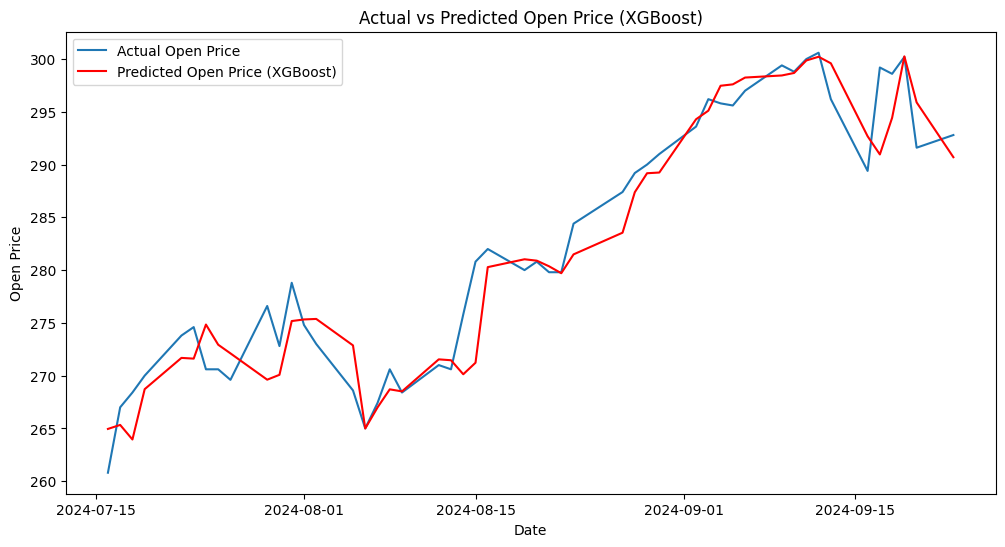

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Keep only sentiment and open related columns
data = data[['Open', 'sentiment_score','High','Low','Close']]

# Feature Engineering: Adding Technical Indicators
data['sentiment_lag_1'] = data['sentiment_score'].shift(1)
data['sentiment_lag_2'] = data['sentiment_score'].shift(2)
data['sentiment_roll_mean_3'] = data['sentiment_score'].rolling(window=3).mean()
data['sentiment_roll_std_3'] = data['sentiment_score'].rolling(window=3).std()
data['open_roll_mean_3'] = data['Open'].rolling(window=3).mean()
data['open_roll_std_3'] = data['Open'].rolling(window=3).std()
data['MA10'] = data['Open'].rolling(window=10).mean()
data['MA50'] = data['Open'].rolling(window=50).mean()
data['Volatility'] = data['Open'].rolling(window=10).std()

# Drop missing values after feature engineering
data.dropna(inplace=True)

# Select features and target
features = ['sentiment_score', 'sentiment_lag_1', 'sentiment_lag_2', 'sentiment_roll_mean_3', 'sentiment_roll_std_3',
            'open_roll_mean_3', 'open_roll_std_3', 'MA10', 'MA50', 'Volatility']
target = 'Open'

# Train-test split
train_size = int(len(data) * 0.8)
train = data[:train_size]
test = data[train_size:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Initialize and train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'XGBoost MSE: {mse}')
print(f'XGBoost MAE: {mae}')
print(f'XGBoost RMSE: {rmse}')

# Plot Actual vs Predicted Open Price (XGBoost)
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual Open Price')
plt.plot(test.index, y_pred, label='Predicted Open Price (XGBoost)', color='red')
plt.title('Actual vs Predicted Open Price (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend()
plt.show()


Prophet

In [ ]:
!pip install prophet # install the library

          ds           y
0 2023-09-25  272.799988
1 2023-09-26  268.600006
2 2023-09-27  260.899994
3 2023-09-28  252.899994
4 2023-09-29  252.500000


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp81tvq8zo/fc3sxr8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp81tvq8zo/9q0rvwgh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36873', 'data', 'file=/tmp/tmp81tvq8zo/fc3sxr8h.json', 'init=/tmp/tmp81tvq8zo/9q0rvwgh.json', 'output', 'file=/tmp/tmp81tvq8zo/prophet_modellz8v2pov/prophet_model-20240924141716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:17:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:17:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds
613 2025-09-19
614 2025-09-20
615 2025-09-21
616 2025-09-22
617 2025-09-23
            ds        yhat  yhat_lower  yhat_upper
613 2025-09-19  487.063990  104.364553  908.850598
614 2025-09-20  489.851556  106.109961  915.378629
615 2025-09-21  490.368353  106.878021  917.330898
616 2025-09-22  488.034548   98.913265  914.440893
617 2025-09-23  488.394562  102.997780  919.224952


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


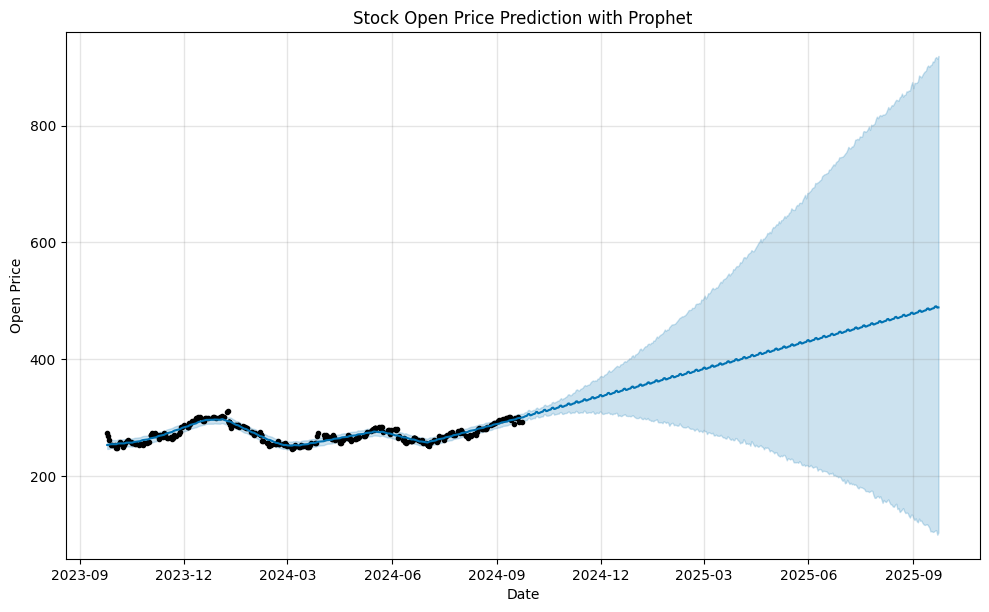

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

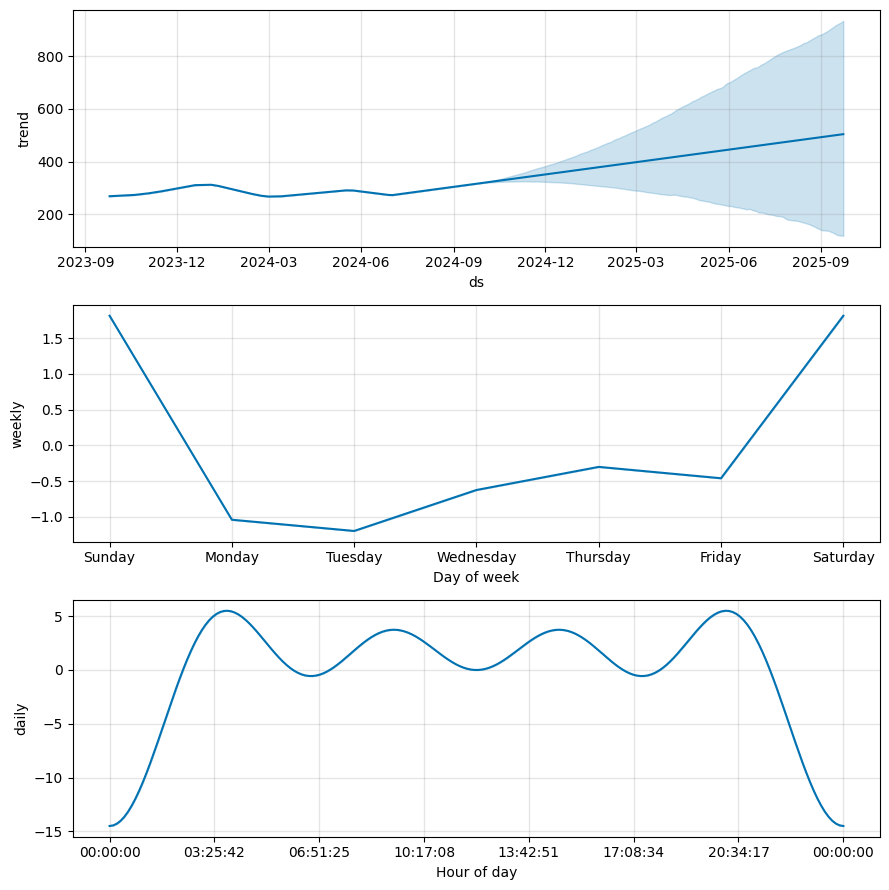

RMSE: 15.961106491915288
MAE: 12.724215818833228


In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Prophet requires the data to have two columns: 'ds' (dates) and 'y' (target variable)
# Create a DataFrame with Date as 'ds' and Open price as 'y'
prophet_data = data[['Open']].reset_index()
prophet_data.rename(columns={'Date': 'ds', 'Open': 'y'}, inplace=True)

# Display the first few rows of the data
print(prophet_data.head())

# Initialize the Prophet model
prophet_model = Prophet(daily_seasonality=True)

# Fit the model to the data
prophet_model.fit(prophet_data)

# Make future predictions
# Create a dataframe with future dates
future_dates = prophet_model.make_future_dataframe(periods=365)  # Forecast for the next 365 days
print(future_dates.tail())

# Make predictions
forecast = prophet_model.predict(future_dates)

# Display the predictions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecasted values
prophet_model.plot(forecast)
plt.title('Stock Open Price Prediction with Prophet')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.show()

# Plot forecast components (trend, yearly seasonality, etc.)
prophet_model.plot_components(forecast)
plt.show()

# Model Evaluation: Calculate RMSE and MAE on historical data
actual = prophet_data['y'].values
predicted = forecast['yhat'][:len(actual)].values  # Prophet gives future predictions, so match the length of actual data

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp81tvq8zo/lnszae9_.json


          ds           y
0 2023-09-25  272.799988
1 2023-09-26  268.600006
2 2023-09-27  260.899994
3 2023-09-28  252.899994
4 2023-09-29  252.500000


DEBUG:cmdstanpy:input tempfile: /tmp/tmp81tvq8zo/tfvfa1jb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35531', 'data', 'file=/tmp/tmp81tvq8zo/lnszae9_.json', 'init=/tmp/tmp81tvq8zo/tfvfa1jb.json', 'output', 'file=/tmp/tmp81tvq8zo/prophet_modelqbyl4d28/prophet_model-20240924141719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:17:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:17:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds
348 2024-12-28
349 2024-12-29
350 2024-12-30
351 2024-12-31
352 2025-01-01
            ds        yhat  yhat_lower  yhat_upper
348 2024-12-28  352.383362  302.056713  403.692015
349 2024-12-29  352.900159  302.084183  404.851861
350 2024-12-30  350.566354  299.155442  403.841605
351 2024-12-31  350.926368  298.063793  405.013082
352 2025-01-01  352.015609  299.597083  406.966784


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


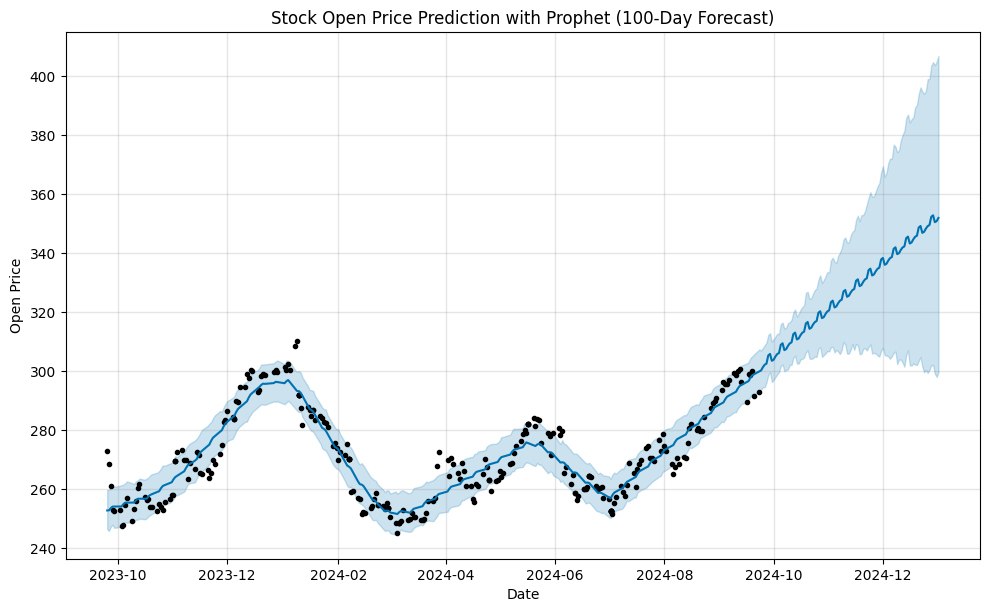

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

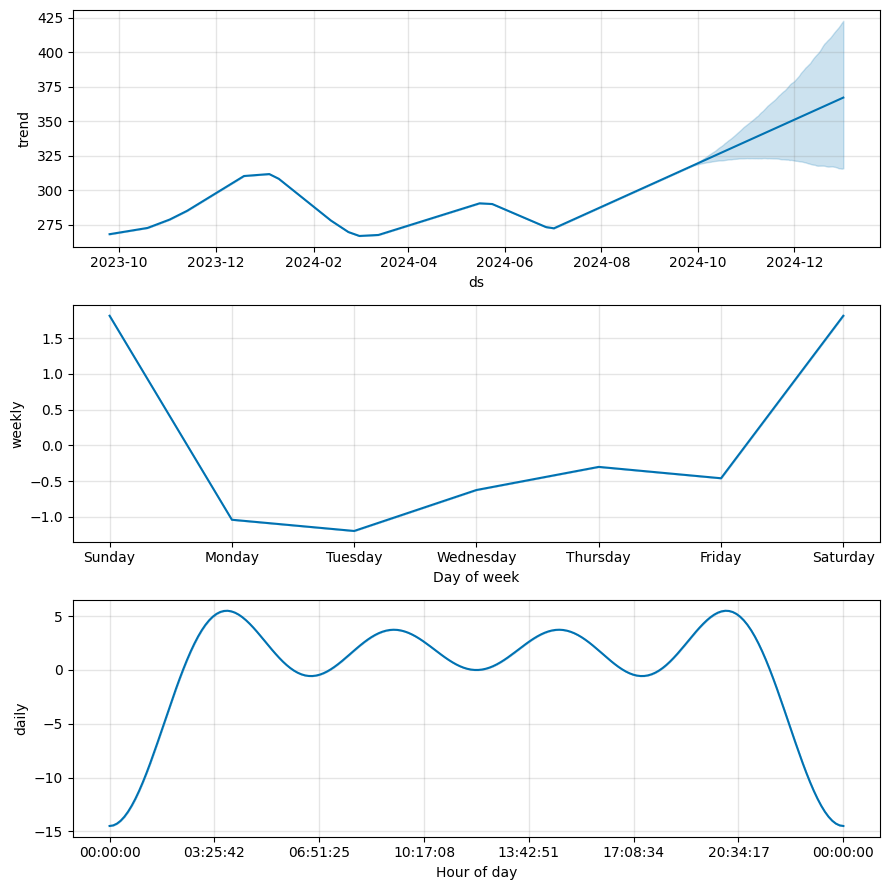

RMSE: 15.961106491915288
MAE: 12.724215818833228


In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Load the merged data with filled sentiment scores
data = pd.read_csv('/content/merged_stock_articles_data_filled_forward.csv')

# Ensure the Date column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set Date as the index
data.set_index('Date', inplace=True)

# Sort data by date
data.sort_index(inplace=True)

# Prophet requires the data to have two columns: 'ds' (dates) and 'y' (target variable)
# Create a DataFrame with Date as 'ds' and Open price as 'y'
prophet_data = data[['Open']].reset_index()
prophet_data.rename(columns={'Date': 'ds', 'Open': 'y'}, inplace=True)

# Display the first few rows of the data
print(prophet_data.head())

# Initialize the Prophet model
prophet_model = Prophet(daily_seasonality=True)

# Fit the model to the data
prophet_model.fit(prophet_data)

# Choose the forecast period: 10 days or 100 days
forecast_periods = 1  # Change to 100 for a 100-day forecast

# Make future predictions
# Create a dataframe with future dates
future_dates = prophet_model.make_future_dataframe(periods=forecast_periods)
print(future_dates.tail())

# Make predictions
forecast = prophet_model.predict(future_dates)

# Display the predictions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecasted values
prophet_model.plot(forecast)
plt.title(f'Stock Open Price Prediction with Prophet ({forecast_periods}-Day Forecast)')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.show()

# Plot forecast components (trend, yearly seasonality, etc.)
prophet_model.plot_components(forecast)
plt.show()

# Model Evaluation: Calculate RMSE and MAE on historical data
# Only compare with actuals up to the most recent data point
if len(forecast) > len(prophet_data):
    actual = prophet_data['y'].values
    predicted = forecast['yhat'][:len(actual)].values  # Prophet gives future predictions, so match the length of actual data

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)

    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
else:
    print("Not enough historical data to calculate RMSE and MAE.")
